In [15]:
!git clone https://github.com/ultralytics/yolov5

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [16]:
#환경설정

%cd yolov5
%pip install -qr requirements.txt

/content/yolov5


In [17]:
import torch
from IPython.display import Image, clear_output  # to display images

#GPU, CPU 사용 유무
clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.7.0+cu101 CPU


Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='data/images/', update=False, view_img=False, weights=['yolov5s.pt'])
YOLOv5 v4.0-77-g3e560e2 torch 1.7.0+cu101 CPU

100% 14.1M/14.1M [00:00<00:00, 43.5MB/s]

Fusing layers... 
Model Summary: 224 layers, 7266973 parameters, 0 gradients, 17.0 GFLOPS
image 1/2 /content/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 bus, Done. (0.302s)
image 2/2 /content/yolov5/data/images/zidane.jpg: 384x640 2 persons, 1 tie, Done. (0.201s)
Results saved to runs/detect/exp
Done. (0.661s)


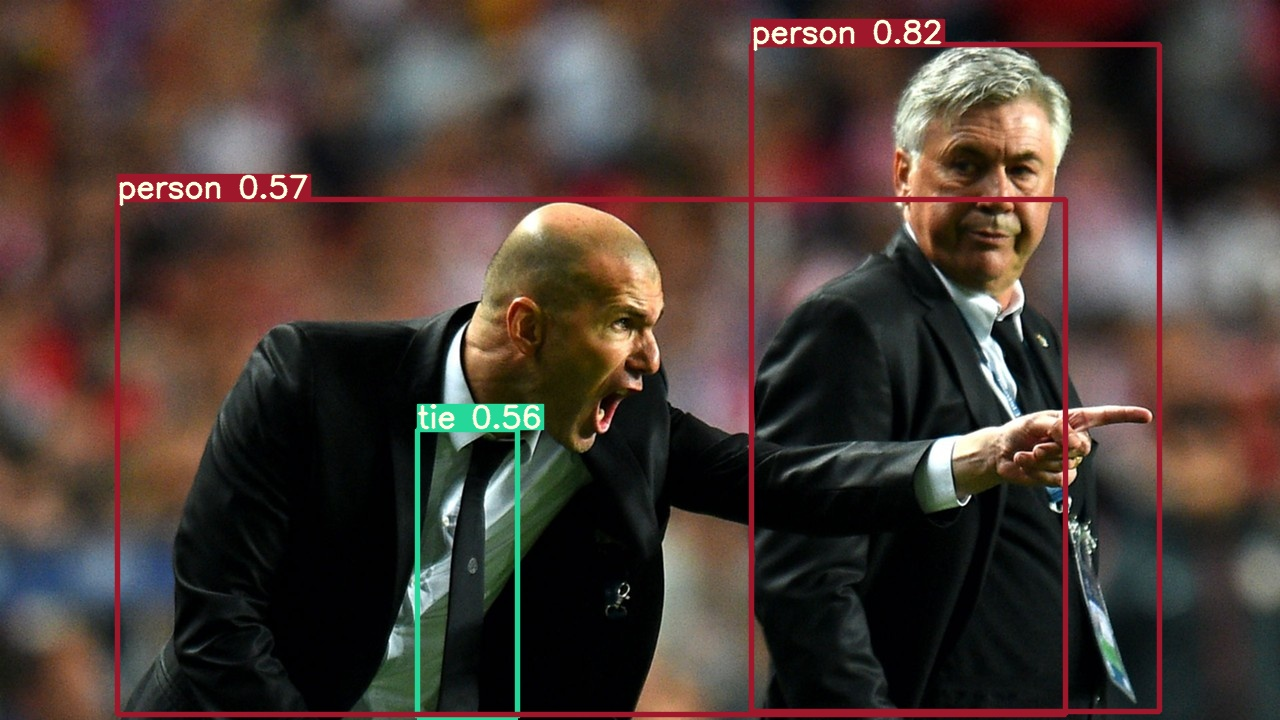

In [18]:
#yolov5 임시 테스트
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images/
Image(filename='runs/detect/exp/zidane.jpg', width=600)

In [ ]:
#실제로 사용하지는 않았습니다.
!pip3 install -U -qq seaborn 

In [19]:
import numpy as np, pandas as pd
from glob import glob
import shutil, os
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import seaborn as sns

In [20]:
fold = 4

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# height width가 담긴 train2.csv height width 역시 kaggle data 에서 찾았음.
train_df = pd.read_csv(f'/content/drive/MyDrive/kaggle/train2.csv')
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,height,width
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2580,2332
1,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R15,NaN,NaN,NaN,NaN,2580,2332
2,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R16,NaN,NaN,NaN,NaN,2580,2332
3,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,3159,2954
4,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R13,NaN,NaN,NaN,NaN,3159,2954


In [24]:
#파일 패스. 임의로 경로 설정하시면 됩니다.
train_df['image_path'] = f'/content/drive/MyDrive/kaggle/train/'+train_df.image_id+'.png'
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,height,width,image_path
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2580,2332,/content/drive/MyDrive/kaggle/train/50a418190b...
1,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R15,NaN,NaN,NaN,NaN,2580,2332,/content/drive/MyDrive/kaggle/train/50a418190b...
2,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R16,NaN,NaN,NaN,NaN,2580,2332,/content/drive/MyDrive/kaggle/train/50a418190b...
3,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,3159,2954,/content/drive/MyDrive/kaggle/train/21a10246a5...
4,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R13,NaN,NaN,NaN,NaN,3159,2954,/content/drive/MyDrive/kaggle/train/21a10246a5...


In [25]:
train_df = train_df[train_df.class_id!=14].reset_index(drop = True)

In [26]:
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,height,width,image_path
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2336,2080,/content/drive/MyDrive/kaggle/train/9a5094b256...
1,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural effusion,10,R9,1789.0,1729.0,1875.0,1992.0,2336,2080,/content/drive/MyDrive/kaggle/train/9a5094b256...
2,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural thickening,11,R9,1789.0,1729.0,1875.0,1992.0,2336,2080,/content/drive/MyDrive/kaggle/train/9a5094b256...
3,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R9,692.0,1375.0,1657.0,1799.0,2336,2080,/content/drive/MyDrive/kaggle/train/9a5094b256...
4,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R8,689.0,1313.0,1666.0,1763.0,2336,2080,/content/drive/MyDrive/kaggle/train/9a5094b256...


In [27]:
#yolo는 비율로 하기 때문에 비율로 고쳐주는 함수
train_df['x_min'] = train_df.apply(lambda row: (row.x_min)/row.width, axis =1)
train_df['y_min'] = train_df.apply(lambda row: (row.y_min)/row.height, axis =1)

train_df['x_max'] = train_df.apply(lambda row: (row.x_max)/row.width, axis =1)
train_df['y_max'] = train_df.apply(lambda row: (row.y_max)/row.height, axis =1)

train_df['x_mid'] = train_df.apply(lambda row: (row.x_max+row.x_min)/2, axis =1)
train_df['y_mid'] = train_df.apply(lambda row: (row.y_max+row.y_min)/2, axis =1)

train_df['w'] = train_df.apply(lambda row: (row.x_max-row.x_min), axis =1)
train_df['h'] = train_df.apply(lambda row: (row.y_max-row.y_min), axis =1)

train_df['area'] = train_df['w']*train_df['h']
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,height,width,image_path,x_mid,y_mid,w,h,area
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,0.332212,0.588613,0.794712,0.783818,2336,2080,/content/drive/MyDrive/kaggle/train/9a5094b256...,0.563462,0.686216,0.462500,0.195205,0.090283
1,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural effusion,10,R9,0.860096,0.740154,0.901442,0.852740,2336,2080,/content/drive/MyDrive/kaggle/train/9a5094b256...,0.880769,0.796447,0.041346,0.112586,0.004655
2,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural thickening,11,R9,0.860096,0.740154,0.901442,0.852740,2336,2080,/content/drive/MyDrive/kaggle/train/9a5094b256...,0.880769,0.796447,0.041346,0.112586,0.004655
3,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R9,0.332692,0.588613,0.796635,0.770120,2336,2080,/content/drive/MyDrive/kaggle/train/9a5094b256...,0.564663,0.679366,0.463942,0.181507,0.084209
4,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R8,0.331250,0.562072,0.800962,0.754709,2336,2080,/content/drive/MyDrive/kaggle/train/9a5094b256...,0.566106,0.658390,0.469712,0.192637,0.090484


In [ ]:
# 5개의 Fold, KFold 참조
gkf  = GroupKFold(n_splits = 5)
train_df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, groups = train_df.image_id.tolist())):
    train_df.loc[val_idx, 'fold'] = fold
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,height,width,image_path,x_mid,y_mid,w,h,area,fold
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,0.332212,0.588613,0.794712,0.783818,2336,2080,/content/drive/MyDrive/kaggle/train/9a5094b256...,0.563462,0.686216,0.462500,0.195205,0.090283,3
1,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural effusion,10,R9,0.860096,0.740154,0.901442,0.852740,2336,2080,/content/drive/MyDrive/kaggle/train/9a5094b256...,0.880769,0.796447,0.041346,0.112586,0.004655,3
2,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural thickening,11,R9,0.860096,0.740154,0.901442,0.852740,2336,2080,/content/drive/MyDrive/kaggle/train/9a5094b256...,0.880769,0.796447,0.041346,0.112586,0.004655,3
3,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R9,0.332692,0.588613,0.796635,0.770120,2336,2080,/content/drive/MyDrive/kaggle/train/9a5094b256...,0.564663,0.679366,0.463942,0.181507,0.084209,3
4,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R8,0.331250,0.562072,0.800962,0.754709,2336,2080,/content/drive/MyDrive/kaggle/train/9a5094b256...,0.566106,0.658390,0.469712,0.192637,0.090484,3


In [ ]:
train_files = []
val_files   = []
val_files += list(train_df[train_df.fold==fold].image_path.unique())
train_files += list(train_df[train_df.fold!=fold].image_path.unique())
len(train_files), len(val_files)


(3515, 879)

In [ ]:
# 먼저 각 txt 생성
label_dir = '/content/drive/MyDrive/kaggle/train_labels/'
for i in train_df['image_id'].unique():
  f = open(f'{label_dir}{i}.txt','w')
  f.close()

In [ ]:
print(train_df.iloc[0])

image_id                       9a5094b2563a1ef3ff50dc5c7ff71345
class_name                                         Cardiomegaly
class_id                                                      3
rad_id                                                      R10
x_min                                                  0.332212
y_min                                                  0.588613
x_max                                                  0.794712
y_max                                                  0.783818
height                                                     2336
width                                                      2080
image_path    /content/drive/MyDrive/kaggle/train/9a5094b256...
x_mid                                                  0.563462
y_mid                                                  0.686216
w                                                        0.4625
h                                                      0.195205
area                                    

In [ ]:
#txt 마다 증상 적기, 만약 많은 증상이 있다면 다음줄로 넘어가서 적기 텍스트를 추가해야하기 때문에 'a'사용
label_dir = '/content/drive/MyDrive/kaggle/train_labels/'
for i in range(len(train_df)):
  train_data = train_df.iloc[i]
  filename = train_data['image_id']
  f = open(f'{label_dir}{filename}.txt','a')
  f.write(f"{train_data['class_id']} {train_data['x_mid']} {train_data['y_mid']} {train_data['w']} {train_data['h']}\n")
  f.close()


In [ ]:
# 이것을 labels , images, train, val 로 자동으로 나눠주기 기본으로 했을 때 20분정도 걸린걸로
os.makedirs('/content/drive/MyDrive/kaggle/labels/train', exist_ok = True)
os.makedirs('/content/drive/MyDrive/kaggle/labels/val', exist_ok = True)
os.makedirs('/content/drive/MyDrive/kaggle/images/train', exist_ok = True)
os.makedirs('/content/drive/MyDrive/kaggle/images/val', exist_ok = True)
label_dir = '/content/drive/MyDrive/kaggle/train_labels'
for file in tqdm(train_files):
    shutil.copy(file, '/content/drive/MyDrive/kaggle/images/train')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir, filename+'.txt'), '/content/drive/MyDrive/kaggle/labels/train')
    
for file in tqdm(val_files):
    shutil.copy(file, '/content/drive/MyDrive/kaggle/images/val')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir, filename+'.txt'), '/content/drive/MyDrive/kaggle/labels/val')

In [ ]:
#yolo classes
class_ids, class_names = list(zip(*set(zip(train_df.class_id, train_df.class_name))))
classes = list(np.array(class_names)[np.argsort(class_ids)])
classes = list(map(lambda x: str(x), classes))
classes

['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

In [ ]:
from os import listdir
from os.path import isfile, join
import yaml
# yolo train.txt val.txt 적기
cwd = '/content/drive/MyDrive/kaggle/working/'

with open(join( cwd , 'train.txt'), 'w') as f:
    for path in glob('/content/drive/MyDrive/kaggle/images/train/*'):
        f.write(path+'\n')
            
with open(join( cwd , 'val.txt'), 'w') as f:
    for path in glob('/content/drive/MyDrive/kaggle/images/val/*'):
        f.write(path+'\n')

data = dict(
    train =  join( cwd , 'train.txt') ,
    val   =  join( cwd , 'val.txt' ),
    nc    = 14,
    names = classes
    )

with open(join( cwd , 'vinbigdata.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(join( cwd , 'vinbigdata.yaml'), 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- Aortic enlargement
- Atelectasis
- Calcification
- Cardiomegaly
- Consolidation
- ILD
- Infiltration
- Lung Opacity
- Nodule/Mass
- Other lesion
- Pleural effusion
- Pleural thickening
- Pneumothorax
- Pulmonary fibrosis
nc: 14
train: /content/drive/MyDrive/kaggle/working/train.txt
val: /content/drive/MyDrive/kaggle/working/val.txt



In [ ]:
#마지막으로 CPU, GPU 확인 train 시작
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.7.0+cu101 _CudaDeviceProperties(name='Tesla V100-SXM2-16GB', major=7, minor=0, total_memory=16130MB, multi_processor_count=80)


In [ ]:
!WANDB_MODE="dryrun" python /content/yolov5/train.py --img 832 --batch 16 --epochs 30 --data /content/drive/MyDrive/kaggle/working/vinbigdata.yaml --weights /content/yolov5/yolov5s.pt --cache

github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 v4.0-70-gc32b0af torch 1.7.0+cu101 CUDA:0 (Tesla V100-SXM2-16GB, 16130.5MB)

Namespace(adam=False, batch_size=16, bucket='', cache_images=True, cfg='', data='/content/drive/MyDrive/kaggle/working/vinbigdata.yaml', device='', epochs=30, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[832, 832], linear_lr=False, local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp', single_cls=False, sync_bn=False, total_batch_size=16, weights='/content/yolov5/yolov5s.pt', workers=8, world_size=1)
wandb: Install Weights & Biases for YOLOv5 logging with 'pip install wandb' (recommended)
Start Tensorboard with "tensorboard --logdir runs/train", view at http://localhost:6006/
2021-02-10 03:36:05.779977: I tensorflow/stream_

In [ ]:
!python detect.py --weights 'runs/train/exp/weights/best.pt' --img 640 --conf 0.15 --iou 0.5 --source /content/drive/MyDrive/kaggle/images/val/ --exist-ok

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.15, device='', exist_ok=True, img_size=640, iou_thres=0.5, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/content/drive/MyDrive/kaggle/images/val/', update=False, view_img=False, weights=['runs/train/exp/weights/best.pt'])
YOLOv5 v4.0-70-gc32b0af torch 1.7.0+cu101 CUDA:0 (Tesla V100-SXM2-16GB, 16130.5MB)

Fusing layers... 
Model Summary: 224 layers, 7088971 parameters, 0 gradients, 16.4 GFLOPS
image 1/879 /content/drive/MyDrive/kaggle/images/val/00675cd546313f912cadd4ad54415d69.png: 640x640 1 Aortic enlargement, 1 Cardiomegaly, 1 Pleural thickening, Done. (0.009s)
image 2/879 /content/drive/MyDrive/kaggle/images/val/009d4c31ebf87e51c5c8c160a4bd8006.png: 640x640 1 Aortic enlargement, 1 Cardiomegaly, 1 Lung Opacity, 1 Nodule/Mass, 1 Pleural effusion, Done. (0.010s)
image 3/879 /content/drive/MyDrive/kaggle/images/val/00bcb82818ea83d6a86df241762cd7d0.png: 640x640 2 Aortic enlargements, 1 

# /yolov5/runs/detect/exp 에 저장되어있음

In [ ]:
# best.pt 파일 저장 이것이 weight

shutil.copy('runs/train/exp/weights/best.pt', '/content/drive/MyDrive/kaggle/working')

'/content/drive/MyDrive/kaggle/working/best.pt'

In [ ]:
!WANDB_MODE="dryrun" python /content/yolov5/train.py --img 832 --batch 20 --epochs 1000 --data /content/drive/MyDrive/kaggle/working/vinbigdata.yaml --weights /content/yolov5/yolov5s.pt --cfg /content/drive/MyDrive/kaggle/working/custom_yolov5s.yaml --cache

github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 v4.0-70-gc32b0af torch 1.7.0+cu101 CUDA:0 (Tesla V100-SXM2-16GB, 16130.5MB)

Namespace(adam=False, batch_size=20, bucket='', cache_images=True, cfg='/content/drive/MyDrive/kaggle/working/custom_yolov5s.yaml', data='/content/drive/MyDrive/kaggle/working/vinbigdata.yaml', device='', epochs=1000, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[832, 832], linear_lr=False, local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp2', single_cls=False, sync_bn=False, total_batch_size=20, weights='/content/yolov5/yolov5s.pt', workers=8, world_size=1)
wandb: Install Weights & Biases for YOLOv5 logging with 'pip install wandb' (recommended)
Start Tensorboard with "tensorboard --logdir runs/train", view at http://loca

In [ ]:
!python detect.py --weights 'runs/train/exp2/weights/best.pt' --img 640 --conf 0.20 --iou 0.4 --source /content/drive/MyDrive/kaggle/test/ --save-txt --save-conf --exist-ok


Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.2, device='', exist_ok=True, img_size=640, iou_thres=0.4, name='exp', project='runs/detect', save_conf=True, save_txt=True, source='/content/drive/MyDrive/kaggle/test/', update=False, view_img=False, weights=['runs/train/exp2/weights/best.pt'])
YOLOv5 v4.0-70-gc32b0af torch 1.7.0+cu101 CUDA:0 (Tesla V100-SXM2-16GB, 16130.5MB)

Fusing layers... 
Model Summary: 224 layers, 7088971 parameters, 0 gradients, 16.4 GFLOPS
image 1/3000 /content/drive/MyDrive/kaggle/test/002a34c58c5b758217ed1f584ccbcfe9.png: 640x640 1 Cardiomegaly, Done. (0.012s)
image 2/3000 /content/drive/MyDrive/kaggle/test/004f33259ee4aef671c2b95d54e4be68.png: 640x640 1 Aortic enlargement, Done. (0.011s)
image 3/3000 /content/drive/MyDrive/kaggle/test/008bdde2af2462e86fd373a445d0f4cd.png: 640x640 1 Aortic enlargement, 1 Cardiomegaly, Done. (0.010s)
image 4/3000 /content/drive/MyDrive/kaggle/test/009bc039326338823ca3aa84381f17f1.png: 640x640 1 Aortic enl

In [ ]:
# best.pt 파일 저장 이것이 weight

shutil.copy('runs/train/exp/weights/best.pt', '/content/drive/MyDrive/kaggle/working')

In [ ]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 6.2MB/s 


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import os
import pydicom
from glob import glob
from tqdm.notebook import tqdm
import cv2
from pydicom.pixel_data_handlers.util import apply_voi_lut
# import matplotlib.pyplot as plt
# from skimage import exposure
# import cv2
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!cp -r /content/yolov5/runs/detect/exp/labels /content/drive/MyDrive/kaggle/test_result

In [ ]:
!python --version

Python 3.6.9


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
width_height = pd.read_csv('/content/drive/MyDrive/kaggle/working/test_width_height.csv')

In [3]:
width_height.head()

,id,height,width
0,83caa8a85e03606cf57e49147d7ac569,2880,2304
1,7550347fa2bb96c2354a3716dfa3a69c,3095,2538
2,74b23792db329cff5843e36efb8aa65a,3120,2788
3,94568a546be103177cb582d3e91cd2d8,2430,1994
4,6da36354fc904b63bc03eb3884e0c35c,2376,2056


In [4]:
print(len(width_height))

3000


In [5]:
width_height['PredictionString'] = ""
width_height.head()

,id,height,width,PredictionString
0,83caa8a85e03606cf57e49147d7ac569,2880,2304,
1,7550347fa2bb96c2354a3716dfa3a69c,3095,2538,
2,74b23792db329cff5843e36efb8aa65a,3120,2788,
3,94568a546be103177cb582d3e91cd2d8,2430,1994,
4,6da36354fc904b63bc03eb3884e0c35c,2376,2056,


In [6]:
id = width_height.iloc[3][0]
txt = f'/content/drive/MyDrive/kaggle/test_result/labels/{id}.txt'
with open(txt,'r') as f :
  lines = f.readlines()
  for line in lines:
    print(line)

0 0.54834 0.487305 0.114258 0.115234 0.746094

3 0.54248 0.737305 0.430664 0.123047 0.748047



In [ ]:
# id = width_height.iloc[3][0]
# txt = f'/content/drive/MyDrive/kaggle/test_result/labels/{id}.txt'
# with open(txt,'r') as f :
#   lines = f.readlines()
#   for line in lines:
#     Class,Prop,x_mid,y_mid,width,height = line.split(' ')
#     print(Class, Prop, x_mid, y_mid, width, height)
#     x_min = float(float(x_mid) - float(width)/2)*width_height.iloc[3][2]
#     x_max = float(float(x_mid) + float(width)/2)*width_height.iloc[3][2]
#     y_min = float(float(y_mid) - float(height)/2)*width_height.iloc[3][1]
#     y_max = float(float(y_mid) + float(height)/2)*width_height.iloc[3][1]
#     print(x_min,x_max)
#     STring = width_height.iloc[3,3]
#     STring2 = f"{STring}{Class} {Prop} {x_min} {y_min} {x_max} {y_max} "
#     print(STring2)
#     width_height.iloc[3,3] = STring2
# print('K', width_height.iloc[3])

0 0.54834 0.487305 0.114258 0.115234 0.746094

856.7978719999999 1086.574468
0 0.54834 856.7978719999999 -628.8572700000001 1086.574468 1184.15115 
3 0.54248 0.737305 0.430664 0.123047 0.748047

1347.508311 1592.8640289999998
0 0.54834 856.7978719999999 -628.8572700000001 1086.574468 1184.15115 3 0.54248 1347.508311 137.63641499999997 1592.8640289999998 1955.390625 
K id                                   94568a546be103177cb582d3e91cd2d8
height                                                           2430
width                                                            1994
PredictionString    0 0.54834 856.7978719999999 -628.8572700000001...
Name: 3, dtype: object


In [7]:
for i in tqdm(range(len(width_height))):
  try:
    id = width_height.iloc[i][0]
    txt = f'/content/drive/MyDrive/kaggle/test_result/labels/{id}.txt'
    with open(txt,'r') as f :
      lines = f.readlines()
      for line in lines:
        Class,Prop,x_mid,y_mid,width,height = line.split(' ')
        x_min = int(float(float(x_mid) - float(width)/2)*width_height.iloc[i][2])
        x_max = int(float(float(x_mid) + float(width)/2)*width_height.iloc[i][2])
        y_min = int(float(float(y_mid) - float(height)/2)*width_height.iloc[i][1])
        y_max = int(float(float(y_mid) + float(height)/2)*width_height.iloc[i][1])
        STring = width_height.iloc[i,3]
        STring2 = f"{STring}{Class} {Prop} {x_min} {y_min} {x_max} {y_max} "
        width_height.iloc[i,3] = STring2
  except : 
    width_height.iloc[i,3] = '14 1 0 0 1 1'

In [8]:
width_height2 = width_height.copy()
width_height2.head()

,id,height,width,PredictionString
0,83caa8a85e03606cf57e49147d7ac569,2880,2304,3 0.557617 895 158 1266 2361
1,7550347fa2bb96c2354a3716dfa3a69c,3095,2538,0 0.546387 609 -677 862 1385
2,74b23792db329cff5843e36efb8aa65a,3120,2788,14 1 0 0 1 1
3,94568a546be103177cb582d3e91cd2d8,2430,1994,0 0.54834 856 -628 1086 1184 3 0.54248 1347 13...
4,6da36354fc904b63bc03eb3884e0c35c,2376,2056,13 0.78125 642 -214 704 678 0 0.578125 471 -36...


In [10]:
width_height2 = width_height2.drop(['height','width'],axis=1)
width_height2.head()

,id,PredictionString
0,83caa8a85e03606cf57e49147d7ac569,3 0.557617 895 158 1266 2361
1,7550347fa2bb96c2354a3716dfa3a69c,0 0.546387 609 -677 862 1385
2,74b23792db329cff5843e36efb8aa65a,14 1 0 0 1 1
3,94568a546be103177cb582d3e91cd2d8,0 0.54834 856 -628 1086 1184 3 0.54248 1347 13...
4,6da36354fc904b63bc03eb3884e0c35c,13 0.78125 642 -214 704 678 0 0.578125 471 -36...


In [12]:
width_height2.columns = ['image_id','PredictionString']

In [14]:
width_height2.to_csv('/content/drive/MyDrive/kaggle/result_csv/submission.csv',index=None)
